In [192]:
from iads.data_traitement import traitement
from iads.recommandation import prediction, traitement_reco

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from surprise import (
    SVD,
    SVDpp,
    SlopeOne,
    NMF,
    KNNBasic,
    BaselineOnly,
)
from surprise.model_selection import GridSearchCV

from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate

from lightfm.data import Dataset as LFMDataset
from lightfm.evaluation import reciprocal_rank
from lightfm import LightFM

from tqdm import tqdm
from sklearn.manifold import TSNE
import random

import warnings

warnings.filterwarnings("ignore")

# I. Chargement des données :


In [193]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,Nombre d'avis,Note,categories,description,titre,_id,creators,illustrators,editors,distributors,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,7.58,NaN,marvel united unir contre super vilain red sku...,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,45.0,0,1,1,1,0,1
1,33.0,7.39,NaN,annee printemps million papillon monarque quit...,Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,60.0,0,1,1,0,1,1


In [194]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,date_published,title_review,title,note,author,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020,le festival de Michoacan,Mariposas,7.0,morlockbob,mariposas


In [195]:
users = df_avis["author"].unique()
games = df_jeux["titre"].unique()  # _id
nombre_zeros = len(df_avis) / (len(users) * len(games))
print(nombre_zeros * 100, "% des éléments sont non nuls")

0.07905386549620134 % des éléments sont non nuls


## Statistiques


In [196]:
nb_users = len(users)
nb_jeux = len(games)

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 16365 jeux


In [197]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

Text(0.5, 1.0, 'Distribution des notes des avis')

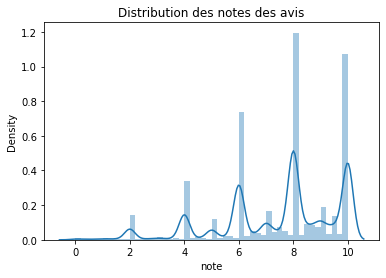

In [198]:
ax = sns.distplot(df_avis["note"])
ax.set_title("Distribution des notes des avis")

Vérification que chaque author n'a donné qu'un seul avis pour un jeu donné :


In [199]:
for i in df_avis.groupby(["author", "title"]):
    if len(i[1]) > 1:
        print("Duplicated author and title")
        df_avis_unique = traitement_reco.delete_dup(df_avis)
        break

Duplicated author and title


In [200]:
print("Nombre d'avis dupliqués : ", len(df_avis) - len(df_avis_unique))

Nombre d'avis dupliqués :  172


In [201]:
def describe_df(df):
    print(f"Nombre d'avis : {len(df)}")
    print(f"Nombre d'utilisateurs : {len(df['author'].unique())}")
    print(f"Nombre de jeux : {len(df['title'].unique())}")

    print("\n====================================================\n")

    _, count = np.unique(df["author"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par utilisateur")
    plt.xlabel("Utilisateurs")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

    print("\n====================================================\n")

    _, count = np.unique(df["title"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par jeu")
    plt.xlabel("Jeux")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

Nombre d'avis : 176071
Nombre d'utilisateurs : 13623
Nombre de jeux : 10709




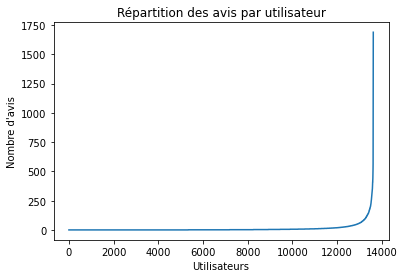

Mean = 12.924539381927623
25th percentile = 1.0
50th percentile = 2.0
75th percentile = 7.0
Minimum = 1
Maximum = 1688
Standard Deviation = 46.04849566072456




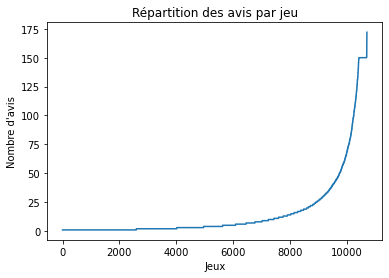

Mean = 16.441404426183585
25th percentile = 2.0
50th percentile = 4.0
75th percentile = 15.0
Minimum = 1
Maximum = 172
Standard Deviation = 31.03411212740304


In [202]:
describe_df(df_avis_unique)

## Collaborative filtering


### Demarrage à froid


On supprime les utilisateurs qui ont commenté moins de 8 fois, et les jeux avec moins de 8 avis ainsi jusqu'à convergence


In [370]:
nb_avis_min = 8

u, df_avis_filter = traitement_reco.clean_user(df_avis_unique, nb_avis_min=nb_avis_min)
g, df_avis_filter = traitement_reco.clean_game(df_avis_filter, nb_avis_min=nb_avis_min)

while u != 0 and g != 0:
    u, df_avis_filter = traitement_reco.clean_user(
        df_avis_filter, nb_avis_min=nb_avis_min)
    
    g, df_avis_filter = traitement_reco.clean_game(
        df_avis_filter, nb_avis_min=nb_avis_min)

In [204]:
game = np.unique(df_avis_unique["title"])
users = np.unique(df_avis_unique["author"])

game_filtred = np.unique(df_avis_filter["title"])
users_filtred = np.unique(df_avis_filter["author"])

print(
    "On a eliminé",
    100 * (len(users) - len(users_filtred)) / len(users),
    "% des utilisateurs",
)

print("On a eliminé", 100 * (len(game) - len(game_filtred)) / len(game), "% des jeux")

print(
    "On a eliminé",
    100 * (len(df_avis_unique) - len(df_avis_filter)) / len(df_avis_unique),
    "% des avis",
)

On a eliminé 77.17096087499083 % des utilisateurs
On a eliminé 66.35540199831917 % des jeux
On a eliminé 23.74212675568379 % des avis


Nombre d'avis : 134268
Nombre d'utilisateurs : 3110
Nombre de jeux : 3603




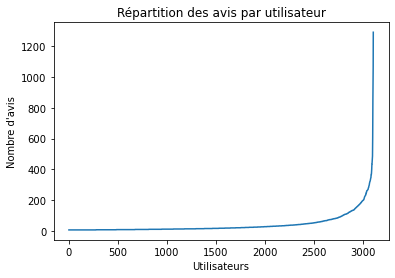

Mean = 43.17299035369775
25th percentile = 11.0
50th percentile = 19.0
75th percentile = 42.0
Minimum = 8
Maximum = 1289
Standard Deviation = 73.00046013859675




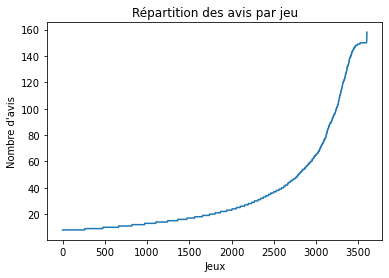

Mean = 37.265611990008324
25th percentile = 12.0
50th percentile = 20.0
75th percentile = 45.0
Minimum = 8
Maximum = 158
Standard Deviation = 38.495177090945695


In [205]:
describe_df(df_avis_filter)

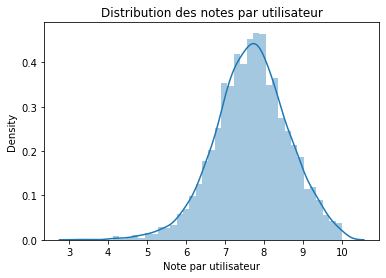

In [206]:
g_users = df_avis_filter.groupby("author")["note"].mean()
ax = sns.distplot(g_users[users_filtred])
ax.set_title("Distribution des notes par utilisateur")
ax.set_xlabel("Note par utilisateur")
plt.show()

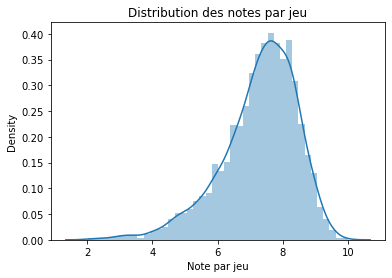

In [207]:
g_game = df_avis_filter.groupby("title")["note"].mean()
ax = sns.distplot(g_game[game_filtred])
ax.set_title("Distribution des notes par jeu")
ax.set_xlabel("Note par jeu")
plt.show()

In [208]:
train_ratings, test_ratings = train_test_split(df_avis_filter, test_size=0.2)

train_ratings = pd.concat([train_ratings, test_ratings[test_ratings.note < 8]], ignore_index=True)
test_ratings = test_ratings[test_ratings.note >= 8]

In [209]:
data = Dataset.load_from_df(train_ratings, Reader(rating_scale=(0, 10)))

In [210]:
already_play = train_ratings.groupby("author")["title"].apply(list).to_dict()

ground_truth = (
    test_ratings
    .groupby("author")["title"]
    .apply(list)
    .to_dict()
)

existing_games = set(train_ratings["title"].unique())

In [211]:
dict_data = {
    "already_play": already_play,
    "ground_truth": ground_truth,
    "existing_games": existing_games,
    "data": data,
}

In [257]:
import itertools
import joblib
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

def model_optim(model_class, param_grid, data, bsl_options=False):

    mse_test = []
    mae_test = []

    mse_train = []
    mae_train = []

    param_combinations = list(itertools.product(*[param_grid[key] for key in param_grid]))

    def _fit(params):
        model = None
        if bsl_options == False:
            model = model_class(verbose=False, **dict(zip(param_grid.keys(), params)))
        else:
            model = model_class(verbose=False, bsl_options=dict(zip(param_grid.keys(), params)))

        mse_test_p = []
        mae_test_p = []

        mse_train_p = []
        mae_train_p = []

        kf = KFold(n_splits=5)
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset)

            mse_test_p.append(accuracy.mse(predictions, verbose=False))
            mae_test_p.append(accuracy.mae(predictions, verbose=False))

            predictions = model.test(trainset.build_testset())

            mse_train_p.append(accuracy.mse(predictions, verbose=False))
            mae_train_p.append(accuracy.mae(predictions, verbose=False))

        return (
            np.mean(mse_test_p),
            np.mean(mae_test_p),
            np.mean(mse_train_p),
            np.mean(mae_train_p),
        )

    results = joblib.Parallel(n_jobs=-1, verbose=5)(
        joblib.delayed(_fit)(params) for params in param_combinations
    )

    mse_test, mae_test, mse_train, mae_train = zip(*results)        
    return {"mse_test": np.array(mse_test), "mae_test": np.array(mae_test), "mse_train": np.array(mse_train), "mae_train": np.array(mae_train), "param_combinations": param_combinations}

def loss_intensity(param_combinations, loss_values, f_param_vals, s_params_vals, f_param_i, s_param_i, f_param_name, s_param_name, loss_name):
    
    f_param_vals = f_param_vals[::-1]
    
    plt.figure(figsize=(10, 5))
    loss_vals = np.zeros((len(f_param_vals), len(s_params_vals)))

    for i, param in enumerate(param_combinations):
        loss_vals[f_param_vals.index(param[f_param_i]), s_params_vals.index(param[s_param_i])] = loss_values[i]
        
    plt.imshow(loss_vals, cmap='viridis')

    plt.yticks(range(len(f_param_vals)), f_param_vals)
    plt.xlabel(f'{s_param_name} values')
    
    plt.xticks(range(len(s_params_vals)), s_params_vals)
    plt.ylabel(f'{f_param_name} values')
    
    plt.title(loss_name)
    plt.colorbar(label='Loss Intensity')
    plt.show()

Naif

In [258]:
mse_mean_val = []
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    testset_ = [t[2] for t in testset]
    predictions = [trainset.global_mean] * len(testset_)
    mse = mean_squared_error(testset_, predictions)
    mse_mean_val.append(mse)
    
mse_mean_val = np.mean(mse_mean)

### Baseline algorithm


`reg_i` represent $\lambda_2$ : 

<img src="img/lambda2.png" />

`reg_u` represent $\lambda_3$ : 

<img src="img/lambda3.png" />

In [317]:
bsl_options = {
    "method": ["als"],
    "reg_u": [5, 10, 15, 20],
    "reg_i": [5, 10, 15, 20]
}

bsl_result = model_optim(BaselineOnly, bsl_options, data, bsl_options=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   12.6s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   22.8s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   23.8s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   24.5s finished


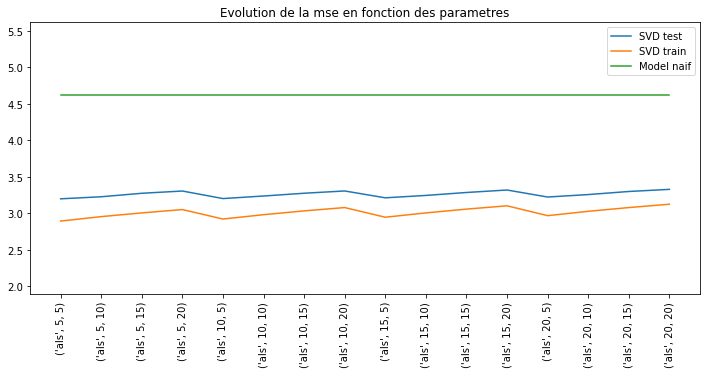

In [318]:
param_combinations = bsl_result["param_combinations"]

mse_test = bsl_result["mse_test"]
mse_train = bsl_result["mse_train"]
mae_test = bsl_result["mae_test"]
mae_train = bsl_result["mae_train"]

mse_mean = [mse_mean_val] * len(param_combinations)

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs = [axs]
plt.subplots_adjust(wspace=0.3)

axs[0].plot(mse_test, label="SVD test")
axs[0].plot(mse_train, label="SVD train")
axs[0].plot(mse_mean, label="Model naif")

axs[0].set_title("Evolution de la mse en fonction des parametres")
axs[0].set_xticks(np.arange(len(param_combinations)))
axs[0].set_xticklabels(param_combinations, rotation=90)
axs[0].set_ylim(np.min([min(mse_test), min(mse_train), min(mse_mean)]) - 1, np.max([max(mse_test), max(mse_train), max(mse_mean)]) + 1)
axs[0].legend()

### SVD algorithm


In [291]:
param_grid = {
    "n_factors": [10*i for i in range(1, 10)],
    "reg_all": [0.1, 1, 5, 20],
}

svd_param_result = model_optim(SVD, param_grid, data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.5min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.7min finished


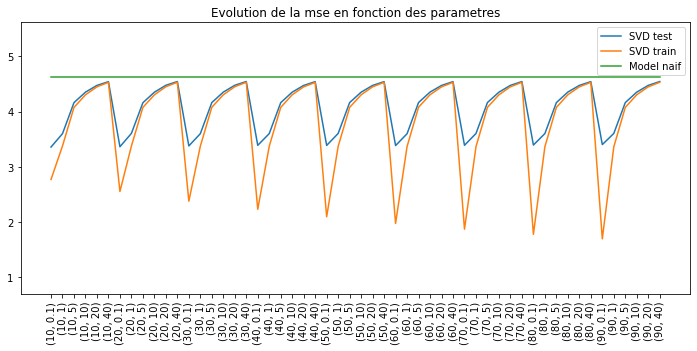

In [298]:
param_combinations = svd_result["param_combinations"]

mse_test = svd_result["mse_test"]
mse_train = svd_result["mse_train"]
mae_test = svd_result["mae_test"]
mae_train = svd_result["mae_train"]

mse_mean = [mse_mean_val] * len(param_combinations)

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs = [axs]
plt.subplots_adjust(wspace=0.3)

axs[0].plot(mse_test, label="SVD test")
axs[0].plot(mse_train, label="SVD train")
axs[0].plot(mse_mean, label="Model naif")

axs[0].set_title("Evolution de la mse en fonction des parametres")
axs[0].set_xticks(np.arange(len(param_combinations)))
axs[0].set_xticklabels(param_combinations, rotation=90)
axs[0].set_ylim(np.min([min(mse_test), min(mse_train), min(mse_mean)]) - 1, np.max([max(mse_test), max(mse_train), max(mse_mean)]) + 1)
axs[0].legend()

In [268]:
param_grid = {
    "n_factors": [10*i for i in range(1, 10)],
    "reg_all": [0.1, 1, 5, 10, 20, 40],
}

svd_result = model_optim(SVD, param_grid, data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed:  2.4min remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.4min finished


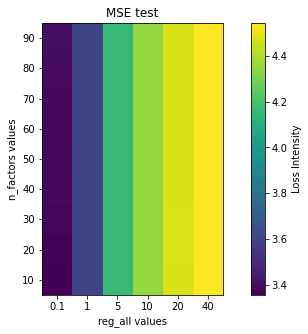

In [299]:
loss_intensity(svd_result["param_combinations"], svd_result["mse_test"], [10*i for i in range(1, 10)], [0.1, 1, 5, 10, 20, 40], 0, 1, "n_factors", "reg_all", "MSE test")

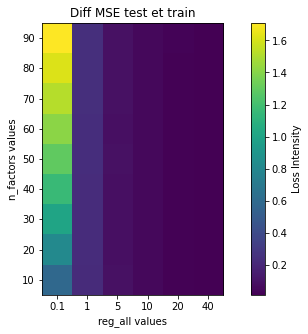

In [301]:
loss_intensity(svd_result["param_combinations"], np.abs(svd_result["mse_test"] - svd_result["mse_train"]), [10*i for i in range(1, 10)], [0.1, 1, 5, 10, 20, 40], 0, 1, "n_factors", "reg_all", "Diff MSE test et train")

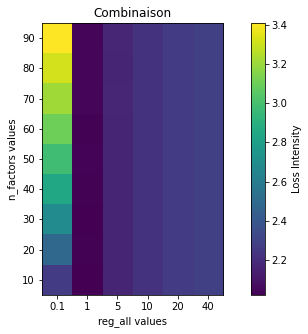

In [368]:
alpha = 0.5
beta = 1
loss_values = alpha * svd_result["mse_test"] + beta * np.abs(svd_result["mse_test"] - svd_result["mse_train"])
loss_intensity(svd_result["param_combinations"], loss_values, [10*i for i in range(1, 10)], [0.1, 1, 5, 10, 20, 40], 0, 1, "n_factors", "reg_all", "Combinaison")

### KNN Basic


In [239]:
sim_options = {
    "name": "cosine",
    "user_based": True,
    "min_support": 5,
}

param_grid = {
    "k": list(range(3, 80, 5)),
    "sim_options": [sim_options],
}

knn_result = model_optim(KNNBasic, param_grid, data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.4min remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished


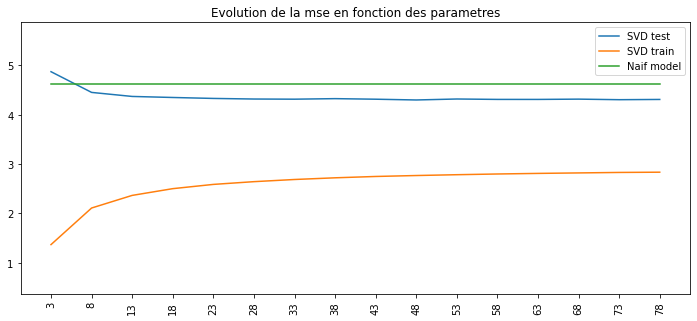

In [307]:
param_combinations = knn_result["param_combinations"]

mse_test = knn_result["mse_test"]
mse_train = knn_result["mse_train"]
mae_test = knn_result["mae_test"]
mae_train = knn_result["mae_train"]

mse_mean = [mse_mean_val] * len(param_combinations)

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs = [axs]
plt.subplots_adjust(wspace=0.3)

axs[0].plot(mse_test, label="SVD test")
axs[0].plot(mse_train, label="SVD train")
axs[0].plot(mse_mean, label="Naif model")

axs[0].set_title("Evolution de la mse en fonction des parametres")
axs[0].set_xticks(np.arange(len(param_combinations)))
axs[0].set_xticklabels([param[0] for param in param_combinations], rotation=90)
axs[0].set_ylim(np.min([min(mse_test), min(mse_train), min(mse_mean)]) - 1, np.max([max(mse_test), max(mse_train), max(mse_mean)]) + 1)
axs[0].legend()

In [337]:
trainset, testset = train_test_split(df_avis_filter, test_size=0.2)

trainset = Dataset.load_from_df(trainset, Reader(rating_scale=(0, 10))).build_full_trainset()
testset = [testset.iloc[i].to_list() for i in range(len(testset))]

In [340]:
models = [
    KNNBasic(k=18, sim_options={"name": "cosine", "user_based": True, "min_support": 5}, verbose=False),
    SVD(n_factors=30, reg_all=1),
    BaselineOnly(bsl_options={"method": "als", "reg_u": 20, "reg_i": 5}, verbose=False)
]

losses = []
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    
    losses.append(accuracy.mse(predictions, verbose=False))

In [347]:
notes_test = [t[2] for t in testset]
predictions = [trainset.global_mean] * len(notes_test)
mse_mean = mean_squared_error(notes_test, predictions)

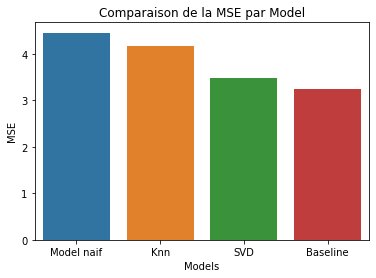

In [352]:
data = {'Models': ["Model naif", "Knn", "SVD", "Baseline"], 'MSE': [mse_mean] + losses}
sns.barplot(x='Models', y='MSE', data=data)

plt.xlabel('Models')
plt.ylabel('MSE')

plt.title('Comparaison de la MSE des modeles')
plt.show()

In [353]:
def get_user_predictions_naif_model(mean, data):
    ground_truth = data["ground_truth"]
    already_play = data["already_play"]
    existing_games = data["existing_games"]

    user_jeux_preference = []

    for user, will_play in tqdm(ground_truth.items()):
        if user not in already_play:
            continue

        l = []
        will_play = set(will_play)
        has_play = set(already_play[user])
        can_play = [
            (game, mean) for game in existing_games - has_play
        ]

        for game, score in reversed(sorted(can_play, key=lambda x: x[1])):
            if game not in will_play:
                l.append(0)
                continue

            l.append(1)
            break

        l[-1] = 1
        user_jeux_preference.append(l)

    return user_jeux_preference

In [355]:
pred_naif = get_user_predictions_naif_model(trainset.global_mean, dict_data)

100%|██████████| 2727/2727 [00:01<00:00, 1378.69it/s]


In [357]:
results_mrr = []

for model in models:
    predictions = prediction.get_user_predictions(model, dict_data)
    results_mrr.append(prediction.mrr(predictions))

100%|██████████| 2727/2727 [00:25<00:00, 107.02it/s]


In [358]:
mrr_naif = prediction.mrr(pred_naif)

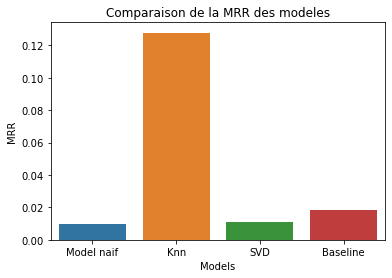

In [360]:
data = {'Models': ["Model naif", "Knn", "SVD", "Baseline"], 'MRR': [mrr_naif] + results_mrr}
sns.barplot(x='Models', y='MRR', data=data)

plt.xlabel('Models')
plt.ylabel('MRR')

plt.title('Comparaison de la MRR des modeles')
plt.show()

### Bayesian Personalized Ranking

In [ ]:
dataset = LFMDataset()
dataset.fit((x for x in df_avis["author"]),
            (x for x in df_avis['title']))

(train_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in train_ratings.itertuples())
)
    
(test_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in test_ratings.itertuples())
)

In [ ]:
bpr = LightFM(loss='bpr')
bpr.fit(train_interactions)

In [ ]:
bpr_mrr = reciprocal_rank(bpr, test_interactions, train_interactions).mean()

In [ ]:
bpr_mrr

0.09855617

## Création d'un systeme de recommandation pour un utilisateur :

In [379]:
def basic_recommand_games(model, user, games, df, nb_games=3):
    scores = []
    
    user_games = list(df[df["author"] == user]["title"])
    
    for game in games:
        
        if game in user_games:
            scores.append(0)
            continue
        
        prediction = model.predict(user, game)
        scores.append(prediction.est)
    
    scores = np.array(scores)
    i_sort = np.argsort(-scores)
    return games[i_sort[:nb_games]]

In [392]:
df_avis_filter["author"] .unique()

array(['*FitzChevalerie*', '--- JD ---', '-Yo-', ..., 'zorl', '§Gama§',
       'égécriéaline'], dtype=object)

In [403]:
author = "égécriéaline"

In [404]:
df_avis_filter[df_avis_filter["author"] == author]

,author,title,note
144754,égécriéaline,Akaba,6.0
24638,égécriéaline,Bandido,7.0
83376,égécriéaline,Black Stories - Morts de rire...,5.0
135973,égécriéaline,Carrousel,8.0
1853,égécriéaline,Caverna,10.0
...,...,...,...
1295,égécriéaline,Unlock! Timeless Adventures,10.0
19804,égécriéaline,Viticulture - Edition Essentielle,8.0
4211,égécriéaline,Wild Space,9.0
155372,égécriéaline,À l'École des Fantômes,6.0


In [405]:
models

In [406]:
knn_games = basic_recommand_games(models[0], author, games, df_avis, nb_games=10)
knn_games

array(['Dungeon Twister : Mercenaires', "Le Siècle d'or", 'Karnag',
       'Ascension : la renaissance de Vigil',
       'Formule Dé : Circuit 10 ème Anniversaire', 'Kingdoms',
       'Les Aventuriers du Rail : Extension Belgique',
       'Heroscape : Fortress of the Archkyrie', 'Cast Enigma', 'Bridge'],
      dtype=object)

In [407]:
svd_games = basic_recommand_games(models[1], author, games, df_avis, nb_games=10)
svd_games

array(['Rallyman : Dirt', 'Twilight Imperium : Shattered Empire',
       'Mémoire 44 : Carnets de Campagne Vol.1', 'Cast Enigma',
       'Antiquity', "Conflict of Heroes : Le Réveil de l'Ours",
       'Dominion - Age des ténèbres', "L'échiquier de Machiavel",
       "Dominion : L'Arrière-Pays", 'Pandemic Legacy - Saison 2'],
      dtype=object)

In [408]:
bs_games = basic_recommand_games(models[2], author, games, df_avis, nb_games=10)
bs_games

array(['Antiquity', 'Rallyman : Dirt',
       'Twilight Imperium : Shattered Empire',
       "Conflict of Heroes : Le Réveil de l'Ours",
       'Dominion - Age des ténèbres', 'A Few Acres of Snow',
       'Cast Enigma', 'Twilight Struggle', 'Goa',
       'Le Trône de Fer - JdS : la bataille des rois'], dtype=object)

In [409]:
common_elements = set(knn_games) & set(bs_games)
percentage = (len(common_elements) / 10) * 100
percentage

10.0

In [410]:
common_elements = set(svd_games) & set(bs_games)
percentage = (len(common_elements) / 10) * 100
percentage

60.0

In [411]:
common_elements = set(knn_games) & set(svd_games)
percentage = (len(common_elements) / 10) * 100
percentage

10.0